In [9]:
import numpy as np
import matplotlib.pyplot as plt
import re
import itertools
import pandas as pd
import matminer
import sys

sys.path.append("/Users/Ashwin/Desktop/git/matminer")

%matplotlib inline

In [2]:
training_file = "data/oqmd_all.csv"

In [3]:
training_set = pd.read_csv(training_file, delim_whitespace=True, na_values=['None'])
training_set

,comp,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability
0,Li1,-1.892002,17.83510,NaN,0.000,0.004605,0.004605
1,Mg1,-1.539604,22.96390,NaN,0.000,0.002719,0.002719
2,Kr1,0.011256,41.41460,NaN,7.367,0.015315,0.015315
3,Na1,-1.299101,32.98260,NaN,0.000,0.003780,0.003780
4,Pd1,-5.158533,15.20880,NaN,0.000,0.018186,0.018186
5,Fe1,-8.125849,11.59730,2.520452,0.000,0.182049,0.182049
6,Gd1,-4.654024,32.26270,-0.002230,0.000,0.001047,0.001047
7,Hf1,-9.923202,22.36760,-0.000068,0.000,0.032166,0.032166
8,Ho1,-4.576627,30.54820,0.007220,0.000,0.000166,0.000559
9,In1,-2.714826,26.81600,NaN,0.000,0.005113,0.005113


In [4]:
min_value = min(np.array(training_set['energy_pa'], dtype=float))
min_value

-144.37591503499999

In [5]:
training_set = training_set.replace(str(min_value), np.nan)
training_set

,comp,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability
0,Li1,-1.892002,17.83510,NaN,0.000,0.004605,0.004605
1,Mg1,-1.539604,22.96390,NaN,0.000,0.002719,0.002719
2,Kr1,0.011256,41.41460,NaN,7.367,0.015315,0.015315
3,Na1,-1.299101,32.98260,NaN,0.000,0.003780,0.003780
4,Pd1,-5.158533,15.20880,NaN,0.000,0.018186,0.018186
5,Fe1,-8.125849,11.59730,2.520452,0.000,0.182049,0.182049
6,Gd1,-4.654024,32.26270,-0.002230,0.000,0.001047,0.001047
7,Hf1,-9.923202,22.36760,-0.000068,0.000,0.032166,0.032166
8,Ho1,-4.576627,30.54820,0.007220,0.000,0.000166,0.000559
9,In1,-2.714826,26.81600,NaN,0.000,0.005113,0.005113


In [6]:
training_set['is_groundstate'] = False

In [7]:
%%time
for gid, group in training_set.groupby('comp'):
    group = group.sort_values('energy_pa', ascending=True)
    training_set.loc[group.iloc[0].name, 'is_groundstate'] = True
training_set.head(100)

CPU times: user 6min 4s, sys: 4.48 s, total: 6min 9s
Wall time: 6min 15s


In [18]:
original_count = len(training_set)
training_set = training_set[training_set['is_groundstate']]
removed = original_count - len(training_set)
print("Removed", removed, "/", original_count)

Removed 118653 / 347329


In [14]:
from pymatgen import Composition
from matminer.descriptors.composition_features import ElementFractionAttribute

In [17]:
training_set_updated = ElementFractionAttribute().featurize_all(training_set, col_id="comp")

In [20]:
print(np.shape(training_set_updated))

(347329, 111)


In [62]:
bandgaps = np.array(training_set_updated["bandgap"], dtype=float)
print(bandgaps)

bg_range = np.zeros(np.shape(bandgaps), dtype=str)
for i in range(len(bandgaps)):
    if bandgaps[i] == 0:
        bg_range[i] = "0"
    elif bandgaps[i] > 0 and bandgaps[i] < 1.5:
        bg_range[i] = "1"
    elif bandgaps[i] >= 1.5 and bandgaps[i] < 3.0:
        bg_range[i] = "2"
    elif bandgaps[i] >= 3.0:
        bg_range[i] = "3"

[ 0.  0.  0. ...,  0.  0.  0.]


In [53]:
cols_to_drop = ['comp', 'energy_pa', 'volume_pa', 'magmom_pa', 'bandgap', 'delta_e', 'stability', 'is_groundstate']

In [63]:
print((np.shape(training_set_updated.drop(cols_to_drop, axis=1))))
print(np.shape(bg_range))

(173910, 103)
(173910,)


In [64]:
from pymatgen import Element
from sklearn.ensemble import RandomForestClassifier

model1 = RandomForestClassifier(n_estimators=10, criterion="gini", min_samples_split=2)
model1.fit(training_set_updated.drop(cols_to_drop, axis=1), bg_range)
prediction = model1.predict(training_set_updated.drop(cols_to_drop, axis=1))

In [65]:
pd.crosstab(bg_range, prediction, rownames=['actual'], colnames=['predicted'])

predicted,0,1,2,3
actua,,,,
,1,0,0,0
0,164339,292,157,101
1,1069,2887,121,53
2,274,176,2503,95
3,41,17,66,1718


In [67]:
from sklearn.tree import DecisionTreeClassifier

model2 = DecisionTreeClassifier()
model2.fit(training_set_updated.drop(cols_to_drop, axis=1), bg_range)
prediction = model2.predict(training_set_updated.drop(cols_to_drop, axis=1))

In [68]:
pd.crosstab(bg_range, prediction, rownames=['actual'], colnames=['predicted'])

predicted,0,1,2,3
actual,,,,
,1,0,0,0
0,164551,149,111,78
1,1111,2922,56,41
2,310,220,2464,54
3,55,22,85,1680


In [69]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()
rf_model.fit(training_set_updated.drop(cols_to_drop, axis=1), bandgaps)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [70]:
prediction = rf_model.predict(training_set_updated.drop(cols_to_drop, axis=1))

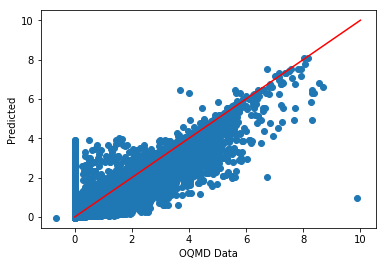

In [71]:
plt.scatter(bandgaps, prediction)
plt.plot(range(11), range(11), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")